In [1]:
import chess
import chess.pgn
import glob
import numpy as np
import utils

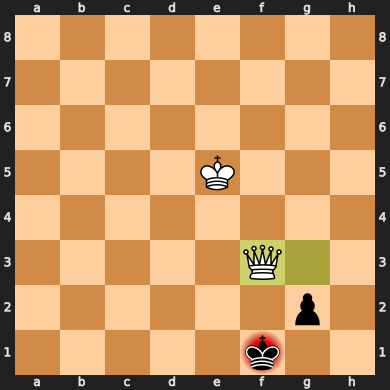

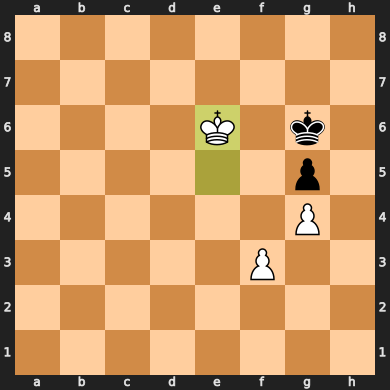

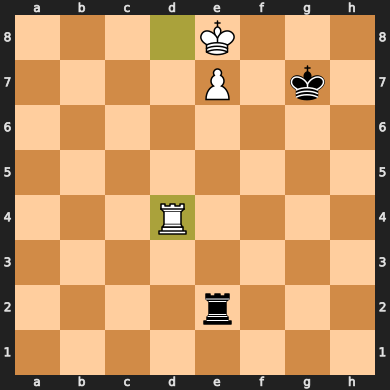

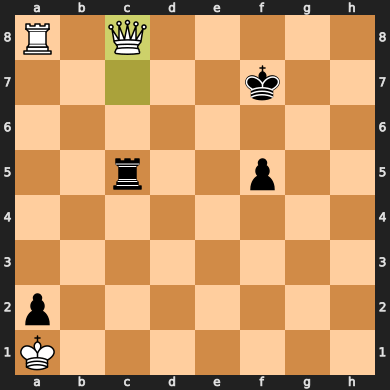

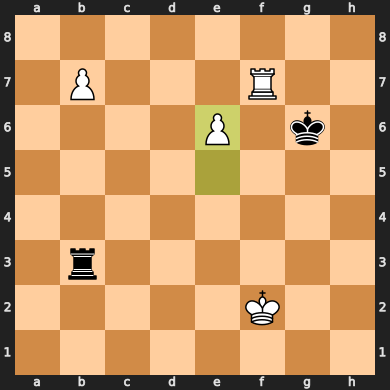

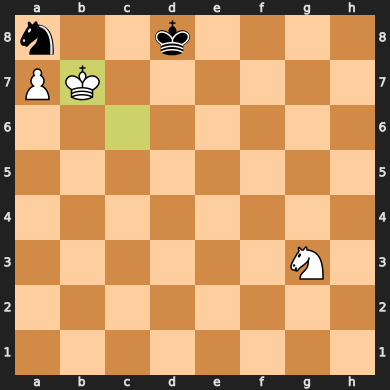

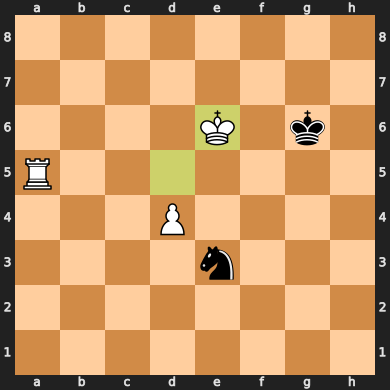

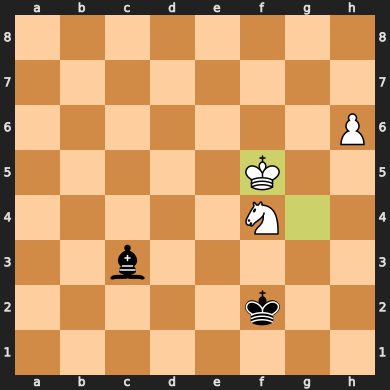

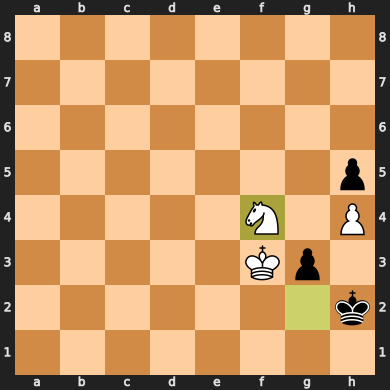

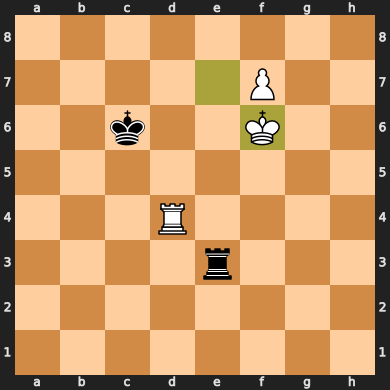

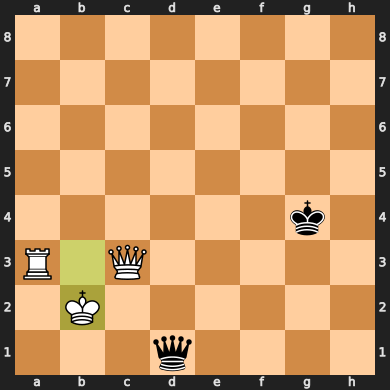

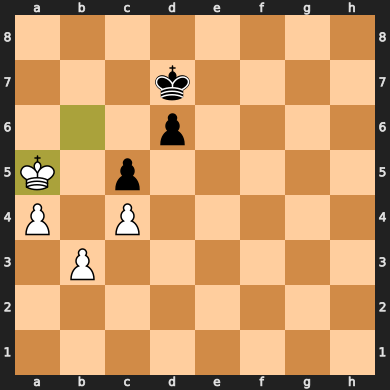

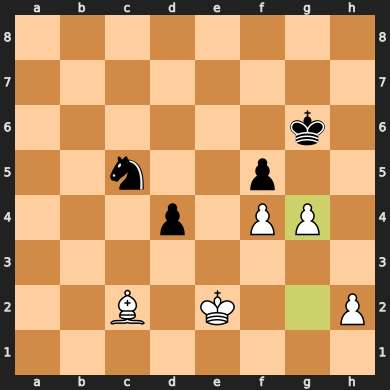

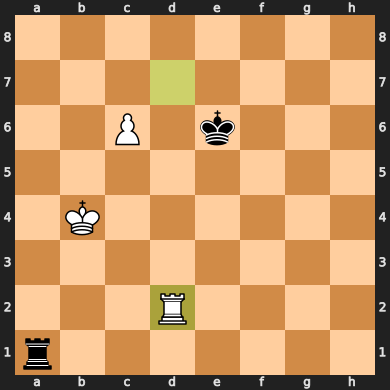

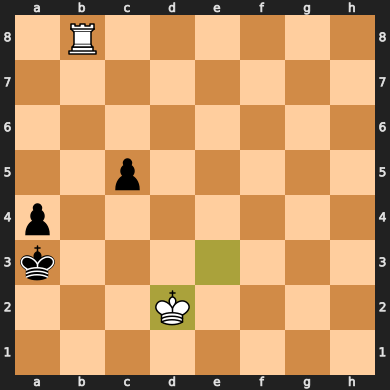

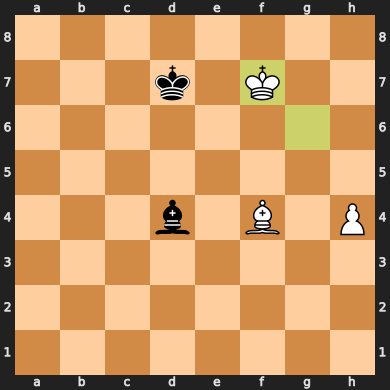

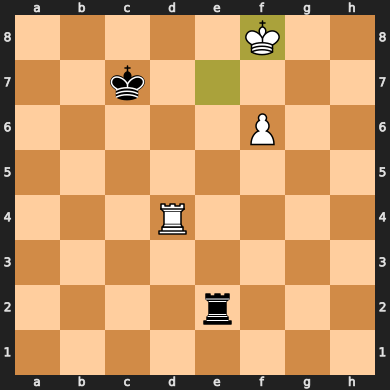

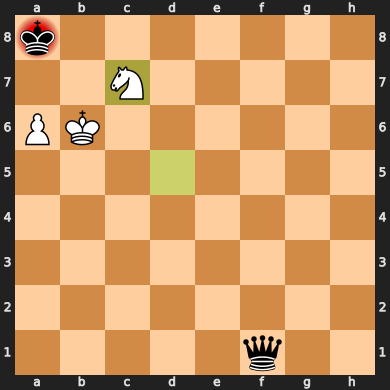

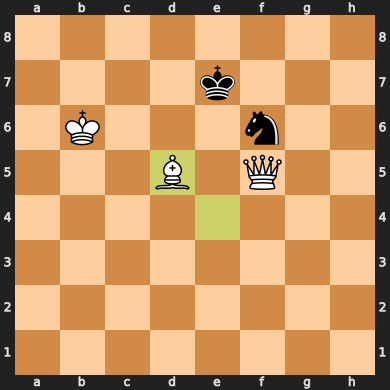

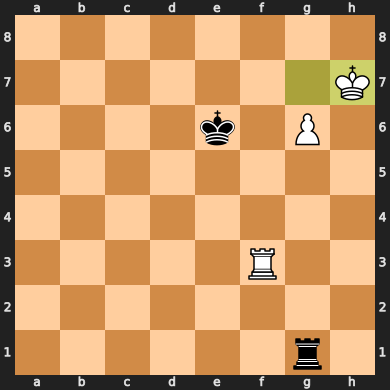

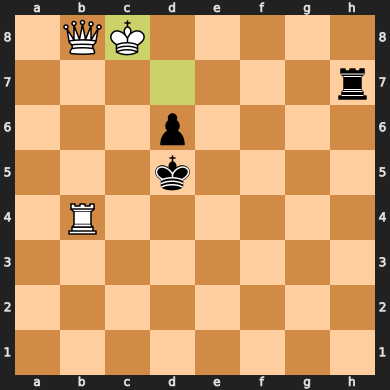

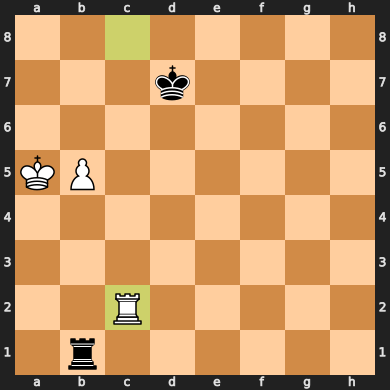

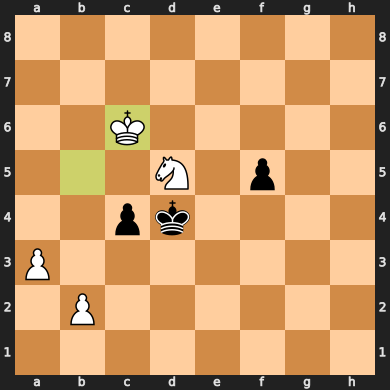

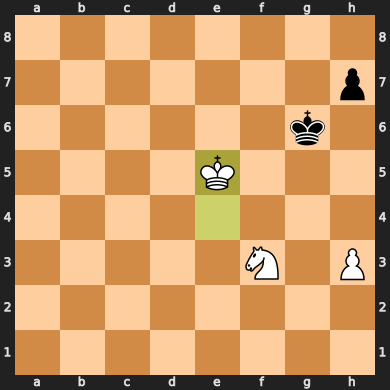

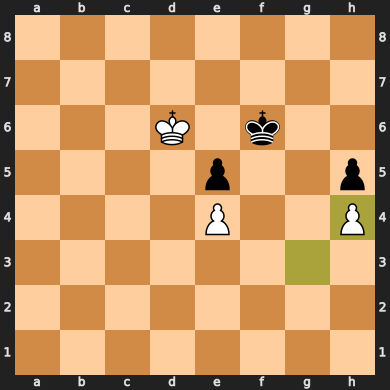

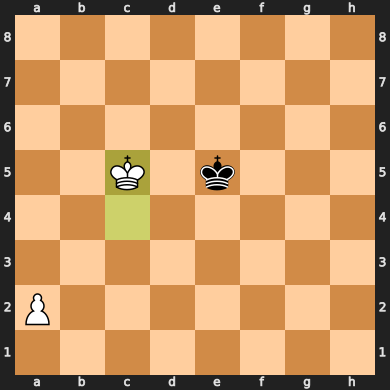

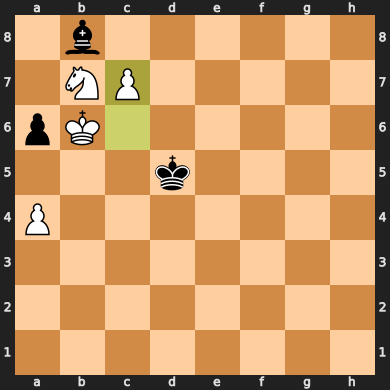

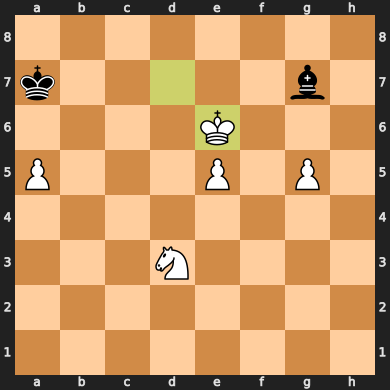

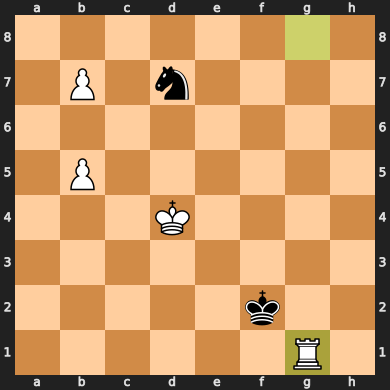

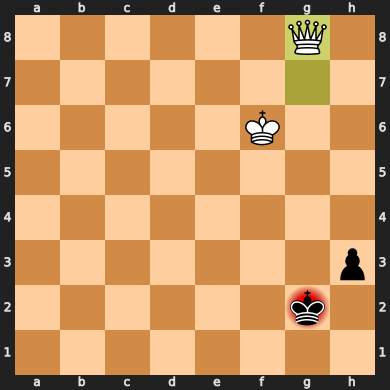

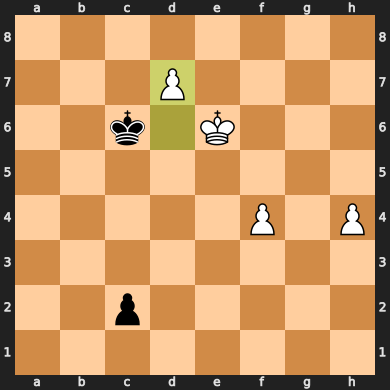

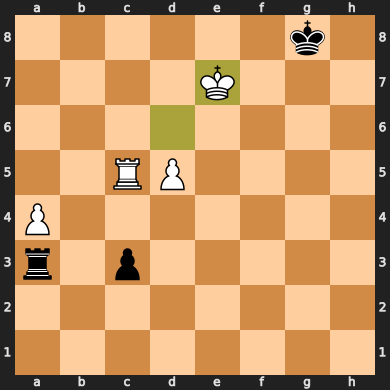

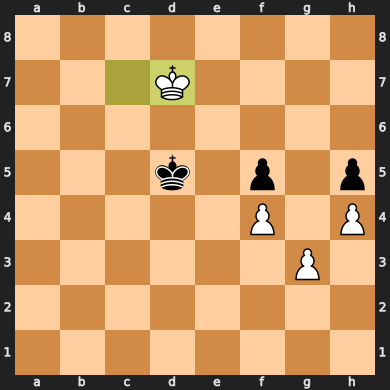

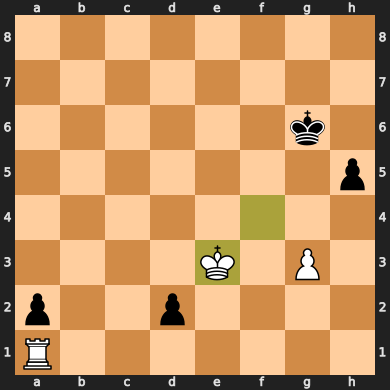

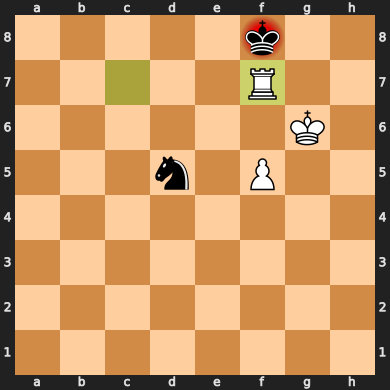

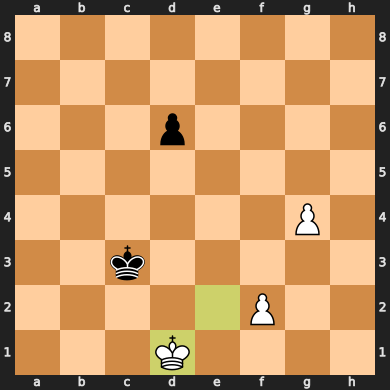

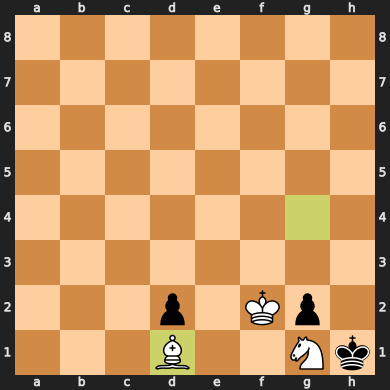

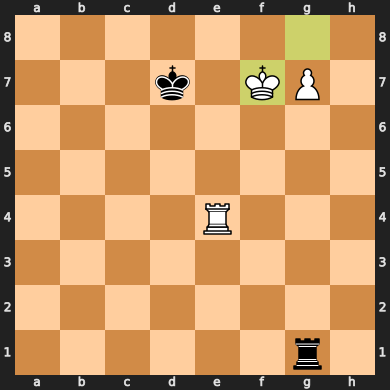

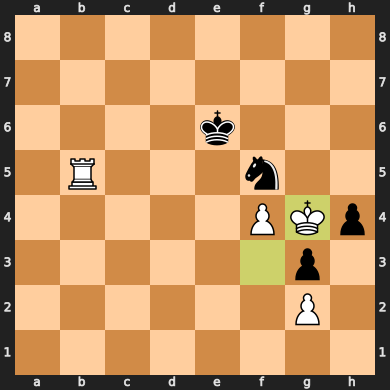

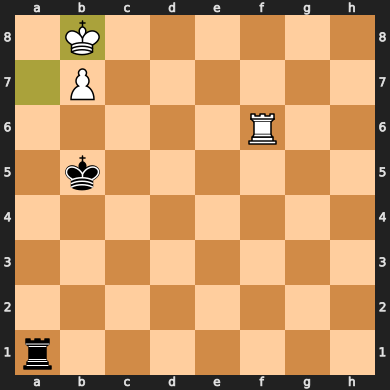

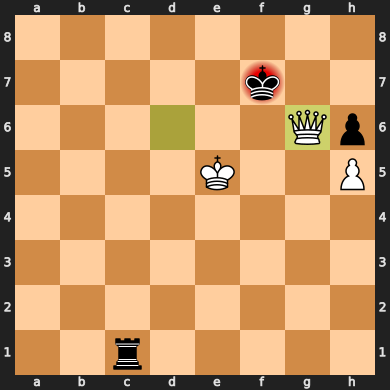

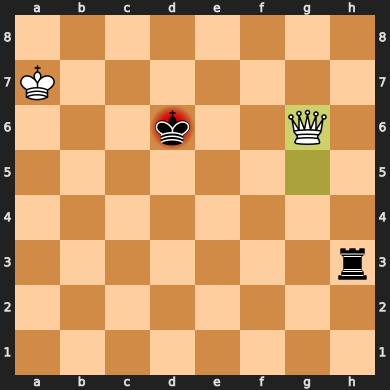

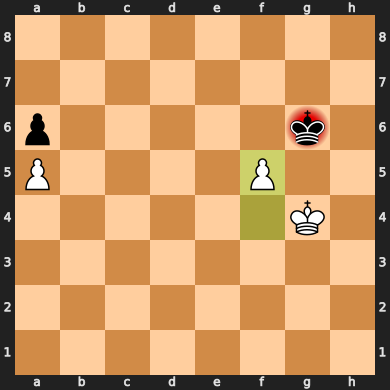

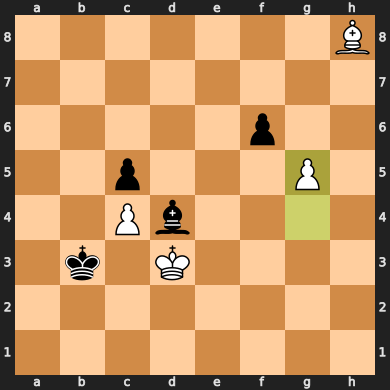

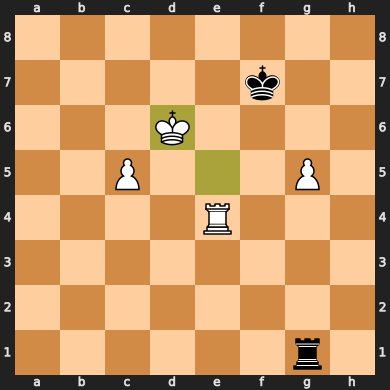

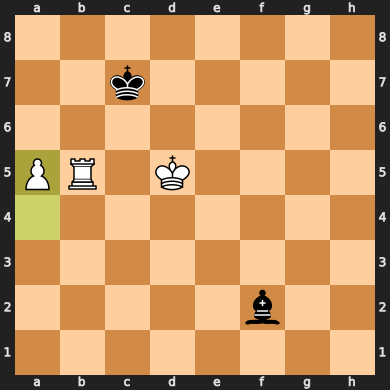

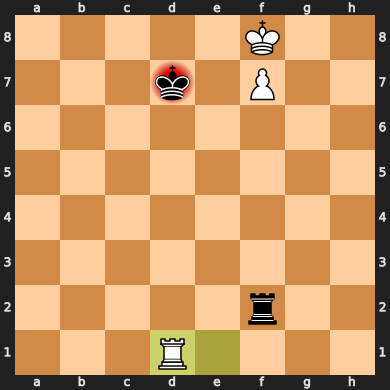

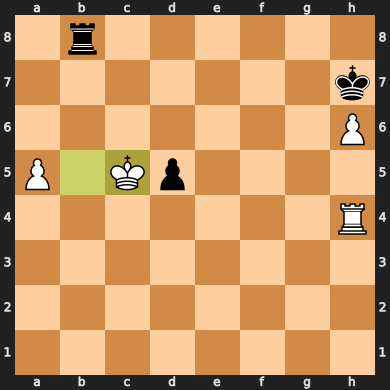

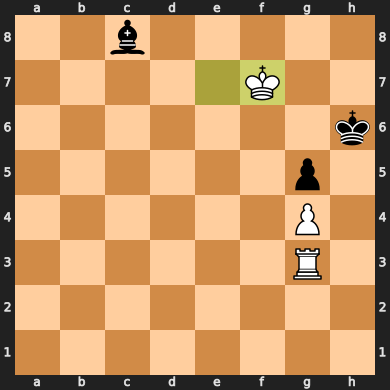

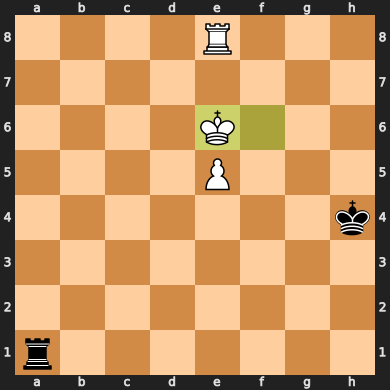

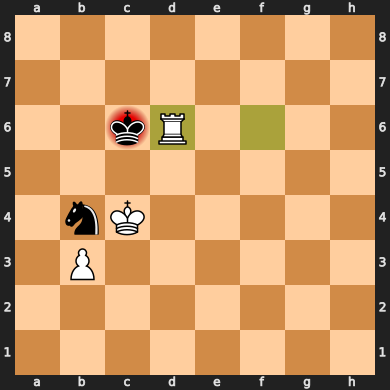

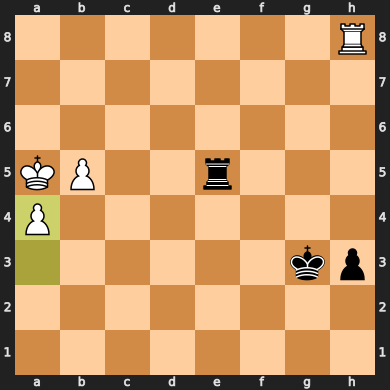

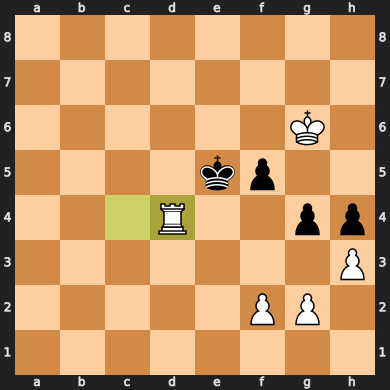

KeyboardInterrupt: 

In [7]:
from stockfish import Stockfish
stockfish = Stockfish(path="./stockfish-ubuntu-x86-64-avx2")

path = 'data/6_less.pgn'

num_games = 0
endplay_games = 0

inputs = []
outputs = []

for filepath in glob.glob(path):
    with open(filepath, encoding="utf-8", errors="ignore") as file:
        while(True):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            num_games += 1
            if (num_games % 500) == 0:
                print(num_games)
            final_board = game.end().board()
            num_pieces = len(final_board.piece_map())
            if (game.headers["Result"] == "1-0"): # just look at white wins for now, as convention
                end_node = game.end()
                node = end_node
                for _ in range(5): # go back 5 plies
                    node = node.parent
                if node.board().turn == chess.WHITE:
                    node = node.parent
                stockfish.set_fen_position(node.board().fen())
                evaluation = stockfish.get_evaluation()
                if ((evaluation['type'] == 'cp') and (evaluation['value']) > 300) or ((evaluation['type'] == "mate") and (evaluation['value'] > 0)): # white is winning
                    x = utils.board_to_tensor(node.board())
                    y = utils.move_to_tensor(node.variations[0].move)
                    inputs.append(x)
                    outputs.append(y)
                    endplay_games += 1

print(num_games, endplay_games)

In [3]:
X = np.stack(inputs)
Y = np.stack(outputs)

np.savez_compressed("data/5_less_tensor.npz", inputs=X, outputs=Y)

Loading NPZ to verify. Rebuild the original board and move

In [4]:
data = np.load("data/5_less_tensor.npz")
X = data['inputs']
Y = data['outputs']

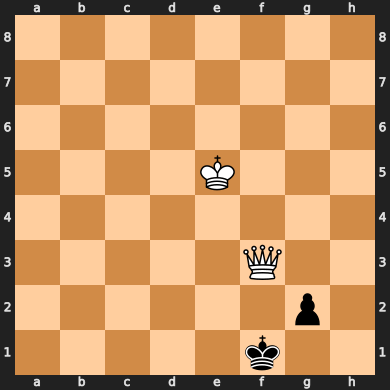

f1g1


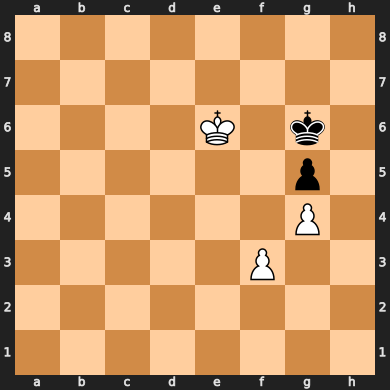

g6g7


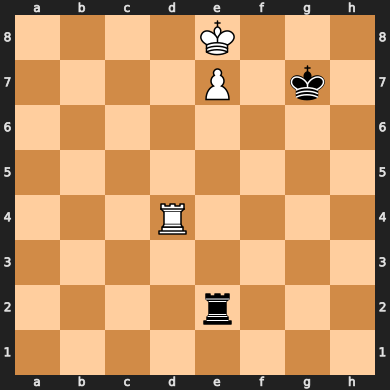

e2e1


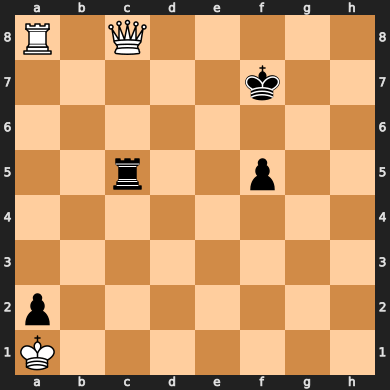

c5c8


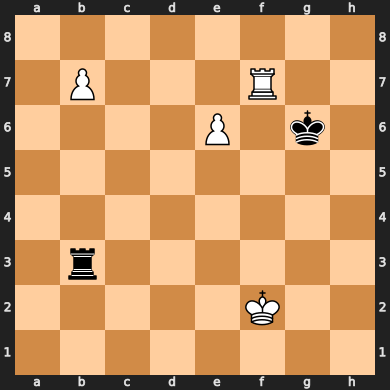

b3b2


In [6]:
for idx in range(5):
    x = X[idx]
    y = Y[idx]
    board = utils.tensor_to_board(x)
    move = utils.tensor_to_move(y)
    display(board)
    print(move)